C:\Users\abdulssekyanzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Loss: 1.3936693668365479
Epoch 2, Loss: 1.2826648950576782
Epoch 3, Loss: 1.2149560451507568
Epoch 4, Loss: 1.0964033603668213
Epoch 5, Loss: 1.1384985446929932
Epoch 6, Loss: 1.0824153423309326
Epoch 7, Loss: 1.000011682510376
Epoch 8, Loss: 0.9660620093345642
Epoch 9, Loss: 0.9691377282142639
Epoch 10, Loss: 0.964990496635437
Epoch 11, Loss: 0.9517009854316711
Epoch 12, Loss: 0.940405011177063
Epoch 13, Loss: 0.9281226396560669
Epoch 14, Loss: 0.9037495851516724
Epoch 15, Loss: 0.8570117950439453
Epoch 16, Loss: 0.8012584447860718
Epoch 17, Loss: 0.7333557605743408
Epoch 18, Loss: 0.7412505745887756
Epoch 19, Loss: 0.6981892585754395
Epoch 20, Loss: 0.6637486219406128
Epoch 21, Loss: 0.6416153907775879
Epoch 22, Loss: 0.6316221356391907
Epoch 23, Loss: 0.6294941902160645
Epoch 24, Loss: 0.6253253221511841
Epoch 25, Loss: 0.6269893646240234
Epoch 26, Loss: 0.5931339263916016
Epoch 27, Loss: 0.5647207498550415
Epoch 28, Loss: 0.6044055223464966
Epoch 29, Loss: 0.59130573272705

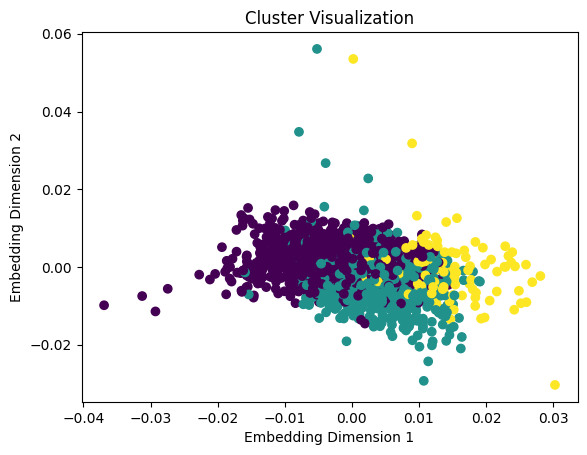

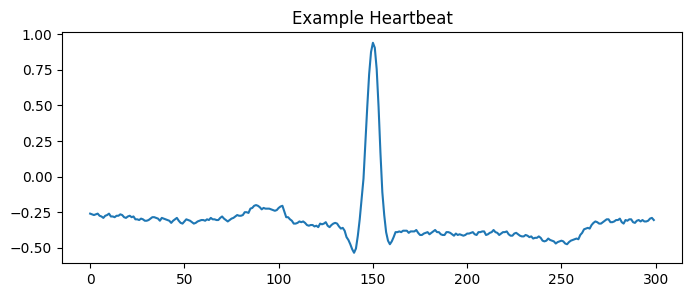

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess(data_path):
    df = pd.read_csv(data_path)
    peaks, _ = find_peaks(df["MLII"], distance=150)
    heartbeats = []
    for peak in peaks:
        start = max(0, peak - 150)
        end = min(len(df), peak + 150)
        heartbeat = df["MLII"][start:end].values
        if len(heartbeat) == 300:
            heartbeats.append(heartbeat)
    heartbeats = np.array(heartbeats).reshape(-1, 300, 1)
    return heartbeats

def augment(heartbeat):
    noise = np.random.normal(0, 0.01, heartbeat.shape)
    time_shift = np.random.randint(-10, 10)
    augmented = tf.roll(heartbeat + noise, shift=time_shift, axis=0) #use tf.roll
    return augmented

data_path = "C:/Users/abdulssekyanzi/EDA Dataset.csv/100.csv" #replace with your path
heartbeats = load_and_preprocess(data_path)

# --- 2. Model Architecture ---
def create_encoder(input_shape):
    model = models.Sequential([
        layers.Conv1D(64, 5, activation="relu", input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128),
    ])
    return model

encoder = create_encoder((300, 1))

# NT-Xent Loss
def nt_xent_loss(embeddings, temperature=0.1):
    batch_size = tf.shape(embeddings)[0] // 2
    embeddings_a = embeddings[:batch_size]
    embeddings_b = embeddings[batch_size:]
    normalized_embeddings_a = tf.nn.l2_normalize(embeddings_a, axis=1)
    normalized_embeddings_b = tf.nn.l2_normalize(embeddings_b, axis=1)
    logits = tf.matmul(normalized_embeddings_a, tf.transpose(normalized_embeddings_b)) / temperature
    labels = tf.range(batch_size)
    loss_a = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    loss_b = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
    return (tf.reduce_mean(loss_a) + tf.reduce_mean(loss_b)) / 2

# --- 3. Training ---
optimizer = optimizers.Adam(0.001)

@tf.function
def train_step(heartbeats_list):
    augmented_heartbeats_a = tf.stack([augment(hb) for hb in heartbeats_list])
    augmented_heartbeats_b = tf.stack([augment(hb) for hb in heartbeats_list])
    with tf.GradientTape() as tape:
        embeddings_a = encoder(augmented_heartbeats_a, training=True)
        embeddings_b = encoder(augmented_heartbeats_b, training=True)
        embeddings = tf.concat([embeddings_a, embeddings_b], axis=0)
        loss = nt_xent_loss(embeddings)
    gradients = tape.gradient(loss, encoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))
    return loss

epochs = 50
batch_size = 32
for epoch in range(epochs):
    for i in range(0, len(heartbeats), batch_size):
        batch = heartbeats[i:i + batch_size]
        loss = train_step(list(batch))
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

# --- 4. Downstream Task (Clustering) ---
embeddings = encoder.predict(heartbeats)

# Determine the optimal number of clusters (example: Silhouette Score)
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, labels))

optimal_clusters = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualize clusters (example: scatter plot of first two dimensions)
if embeddings.shape[1] >= 2:
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels, cmap='viridis')
    plt.title("Cluster Visualization")
    plt.xlabel("Embedding Dimension 1")
    plt.ylabel("Embedding Dimension 2")
    plt.show()

# Example Heartbeat Plot
plt.figure(figsize=(8, 3))
plt.plot(heartbeats[0])
plt.title("Example Heartbeat")
plt.show()